In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

import _utils # amanda's collected utils
from calitp_data_analysis.sql import to_snakecase

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils
import datetime as dt

import gcsfs

from calitp_data.storage import get_fs
fs = get_fs()

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Read In and Clean SWITRS Data

In [2]:
safetyfile = "SWITRS_Full_CA_CV_20230303.xlsx"

In [3]:
# read in collated/cleaned SWITRS data from Safety Office
switrs = (to_snakecase(
    pd.read_excel(f"{_utils.GCS_FILE_PATH}{safetyfile}"))
         ) >> filter(_.sc_accident_year >= 2016)


switrs.head(10)

,sc_case_id,sc_accident_year,proc_date,juris,collision_date,collision_time,officer_id,reporting_district,day_of_week,chp_shift,...,point_x__tb,point_y__tb,near_dist_mile,near_tribe,id_geo,caseid_geo,year_geo,uncertain_possiblycollisionseverity,longitude_geo,latitude_geo
0,8910804,2020,20220618,1900,20200102,205,545623,2834,4,5,...,NaN,NaN,NaN,NaN,152243,8910804,2020,1,-118.226593,33.874409
1,8910805,2020,20211129,5406,20200109,1846,84,2B,4,5,...,NaN,NaN,NaN,NaN,152244,8910805,2020,1,NaN,NaN
2,8910806,2020,20220613,5406,20200129,1433,30,5406,3,5,...,NaN,NaN,NaN,NaN,152245,8910806,2020,1,NaN,NaN
3,8910807,2020,20220611,1941,20200202,1926,6308,NaN,7,5,...,NaN,NaN,NaN,NaN,152246,8910807,2020,1,NaN,NaN
4,8910808,2020,20220618,3905,20200102,452,2718,SEA,4,5,...,NaN,NaN,NaN,NaN,152247,8910808,2020,1,NaN,NaN
5,8910809,2020,20220618,4004,20200105,2219,1425,NaN,7,5,...,NaN,NaN,NaN,NaN,152248,8910809,2020,1,-120.640984,35.662338
6,8910810,2020,20200318,5608,20200209,1922,423,NaN,7,5,...,NaN,NaN,NaN,NaN,152249,8910810,2020,1,NaN,NaN
7,8910811,2020,20220613,3600,20200112,1851,G9467,AP018,7,5,...,NaN,NaN,NaN,NaN,152250,8910811,2020,1,-117.155739,34.471802
8,8910811,2020,20220613,3600,20200112,1851,G9467,AP018,7,5,...,NaN,NaN,NaN,NaN,152250,8910811,2020,1,-117.155739,34.471802
9,8910812,2020,20200318,0103,20200120,1033,104,14,1,5,...,NaN,NaN,NaN,NaN,152262,8910812,2020,1,NaN,NaN


In [4]:
switrs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94733 entries, 0 to 94732
Data columns (total 174 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    sc_case_id                           94733 non-null  int64  
 1    sc_accident_year                     94733 non-null  int64  
 2    proc_date                            94733 non-null  int64  
 3    juris                                94733 non-null  object 
 4    collision_date                       94733 non-null  int64  
 5    collision_time                       94733 non-null  int64  
 6    officer_id                           94633 non-null  object 
 7    reporting_district                   31611 non-null  object 
 8    day_of_week                          94733 non-null  int64  
 9    chp_shift                            94733 non-null  int64  
 10   population                           94733 non-null  int64  
 11   cnty_city_loc

In [5]:
# keep only small subset of columns
switrs_small = (switrs >> select(_.sc_case_id,_.sc_accident_year,_.collision_date,_.collision_time,_.sc_collision_severity,
                                 _.pcf_viol_category,_.type_of_collision,_.mviw,
                                 _.number_killed,_.number_injured,_.pedestrian_accident,_.bicycle_accident,
                                 _.longitude_geo,_.latitude_geo
                            )
               )

In [6]:
# appears to be all tables (crash, pary, victim) merged together; dedup on sc_case_id
# need to test this assumption at some point
switrs_small = switrs_small.drop_duplicates(subset = ['sc_case_id'])

In [7]:
# make geodataframe w/ relevant columns 
switrs_gdf = gpd.GeoDataFrame(
    switrs_small, geometry=gpd.points_from_xy(switrs_small.longitude_geo, switrs_small.latitude_geo))

In [8]:
switrs_gdf.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82513 entries, 0 to 94732
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sc_case_id             82513 non-null  int64   
 1   sc_accident_year       82513 non-null  int64   
 2   collision_date         82513 non-null  int64   
 3   collision_time         82513 non-null  int64   
 4   sc_collision_severity  82513 non-null  int64   
 5   pcf_viol_category      82513 non-null  object  
 6   type_of_collision      82513 non-null  object  
 7   mviw                   82513 non-null  object  
 8   number_killed          82513 non-null  int64   
 9   number_injured         82513 non-null  int64   
 10  pedestrian_accident    15844 non-null  object  
 11  bicycle_accident       5824 non-null   object  
 12  longitude_geo          74741 non-null  float64 
 13  latitude_geo           74741 non-null  float64 
 14  geometry               82513 n

In [9]:
switrs_gdf_geo = (switrs_gdf
                  >> filter(-_.geometry.is_empty)
                 )

<AxesSubplot:>

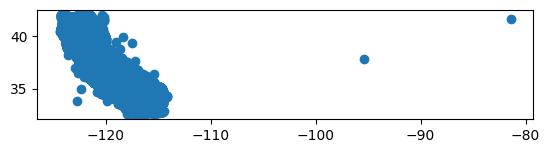

In [10]:
switrs_gdf_geo.plot()

In [11]:
switrs_gdf_geo.head()

,sc_case_id,sc_accident_year,collision_date,collision_time,sc_collision_severity,pcf_viol_category,type_of_collision,mviw,number_killed,number_injured,pedestrian_accident,bicycle_accident,longitude_geo,latitude_geo,geometry
0,8910804,2020,20200102,205,1,11,G,B,1,0,Y,NaN,-118.226593,33.874409,POINT (-118.22659 33.87441)
5,8910809,2020,20200105,2219,1,03,E,I,1,0,NaN,NaN,-120.640984,35.662338,POINT (-120.64098 35.66234)
7,8910811,2020,20200112,1851,1,05,A,C,1,1,NaN,NaN,-117.155739,34.471802,POINT (-117.15574 34.47180)
10,8910813,2020,20200105,2314,1,01,G,G,1,0,NaN,Y,-121.215874,37.787640,POINT (-121.21587 37.78764)
13,8910815,2020,20200222,2158,1,07,E,I,1,1,NaN,NaN,-121.719063,38.551270,POINT (-121.71906 38.55127)


## Data cleaning

In [12]:
# dates and times
switrs_gdf_geo = (switrs_gdf_geo
                 >> mutate(collision_date_str = _.collision_date.astype(str),
                           collision_time_str = _.collision_time.astype(str)
                          )
                 )

In [13]:
switrs_gdf_geo['collision_dt'] = pd.to_datetime(switrs_gdf_geo['collision_date_str'], format='%Y%m%d', yearfirst=True)

In [14]:
switrs_gdf_geo.crs

In [15]:
# set a CRS: assume WGS 84? 
switrs_gdf_geo = switrs_gdf_geo.set_crs('4326')

In [16]:
# project to match project data
switrs_gdf_geo = switrs_gdf_geo.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [17]:
switrs_gdf_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74741 entries, 0 to 94732
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sc_case_id             74741 non-null  int64         
 1   sc_accident_year       74741 non-null  int64         
 2   collision_date         74741 non-null  int64         
 3   collision_time         74741 non-null  int64         
 4   sc_collision_severity  74741 non-null  int64         
 5   pcf_viol_category      74741 non-null  object        
 6   type_of_collision      74741 non-null  object        
 7   mviw                   74741 non-null  object        
 8   number_killed          74741 non-null  int64         
 9   number_injured         74741 non-null  int64         
 10  pedestrian_accident    13937 non-null  object        
 11  bicycle_accident       5127 non-null   object        
 12  longitude_geo          74741 non-null  float64      

In [18]:
# Save out
shared_utils.utils.geoparquet_gcs_export(switrs_gdf_geo, GCS_FILE_PATH, "SWITRS_clean")

In [22]:
# also save a geojson for use in ArcGIS Pro
shared_utils.utils.geojson_gcs_export(switrs_gdf_geo, GCS_FILE_PATH, "SWITRS_clean")  